In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ./drive/MyDrive/bioAI

/content/drive/MyDrive/bioAI


In [ ]:
import random
import os

import numpy as np
import pandas as pd

# 변동이 적은 특징을 제거하는데 사용하는 모듈
from sklearn.feature_selection import VarianceThreshold

# 데이터 셋을 학습, 검증, 테스트 셋으로 분할하는 데 사용하는 모듈
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

# Pytorch에서 데이터셋 처리 및 배치 생성에 사용하는 모듈
from torch.utils.data import Dataset, DataLoader

# rdkit : 화학 구조 및 데이터 처리를 위한 라이브러리
# DataStructs : 데이터 구조 처리
# PandasTools, AllChem : 화학 물질 처리
!pip install rdkit
from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem

from sklearn.ensemble import RandomForestRegressor

from rdkit import Chem
# train model
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 59.1 MB/s eta 0:00:00


In [ ]:
!pip install mglearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 7.2 MB/s eta 0:00:00


In [ ]:
import warnings
# 경고 무시
warnings.filterwarnings("ignore")

In [ ]:
train_data = pd.read_csv('./data/train.csv')

test_data = pd.read_csv('./data/test.csv')

In [ ]:
## 결측치 대처
na_index = train_data[train_data['AlogP'].isna()].index
na_samples = train_data.loc[na_index]


na_index = test_data[test_data['AlogP'].isna()].index
na_samples2 = test_data.loc[na_index]

train_data_notna = train_data.dropna(subset=['AlogP'])
X_train = train_data_notna.drop(['id', 'SMILES', 'MLM', 'HLM', 'AlogP'], axis=1)
y_train = train_data_notna['AlogP']

# model train
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# NA predict
train_data_na = train_data[train_data['AlogP'].isna()]
X_pred = train_data_na.drop(['id', 'SMILES', 'MLM', 'HLM', 'AlogP'], axis=1)
predict_AlogP_train = rf_model.predict(X_pred)

# NA replace
train_data.loc[train_data_na.index, 'AlogP'] = predict_AlogP_train

# test_data NA
test_data_na = test_data[test_data['AlogP'].isna()]
X_test_pred = test_data_na.drop(['id', 'SMILES', 'AlogP'], axis=1)
predict_AlogP_test = rf_model.predict(X_test_pred)
test_data.loc[test_data_na.index, 'AlogP'] = predict_AlogP_test


na_train_check = train_data['AlogP'].isna().sum()
na_test_check = test_data['AlogP'].isna().sum()

na_train_check, na_test_check

(0, 0)

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)

seed_everything(42) # Seed 고정

In [ ]:
# 주어진 mol을 Morgan fingerprint로 변환
# Morgan fingerprint : 화학 물질의 구조와 성질을 나타내는 벡터 형식의 표현
# GetHashedMorganFingerprint() : 화학물질 mol을 입력받아 해당 물질의 fingerprint로 반환

def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 6, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [ ]:
# SMILES 문자열을 사용하여 Molecule 열을 데이터프레임에 train, test 각각 추가
PandasTools.AddMoleculeColumnToFrame(train_data,'SMILES','Molecule')
PandasTools.AddMoleculeColumnToFrame(test_data,'SMILES','Molecule')

In [ ]:
train_data["FPs"] = train_data.Molecule.apply(mol2fp)
test_data["FPs"] = test_data.Molecule.apply(mol2fp)

train_df = train_data[['FPs','MLM', 'HLM']]
test_df = test_data[['FPs']]

In [ ]:
train_data = train_df
test_data = test_df

In [ ]:
def replace_values(df, column):
    train_df = df[df[column] <= 100]
    predict_df = df[df[column] > 100]

    X_train = np.array(train_df['FPs'].tolist())
    X_predict = np.array(predict_df['FPs'].tolist())

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, train_df[column])

    predict_values = rf.predict(X_predict)
    df.loc[predict_df.index, column] = predict_values
    return df

train_data = replace_values(train_data, 'MLM')
train_data = replace_values(train_data, 'HLM')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, target, transform, is_test=False):
        self.df = df
        self.target = target # HLM or MLM
        self.is_test = is_test # train,valid / test

        self.feature_select = transform
        if not self.is_test:
            self.fp = self.feature_select.fit_transform(np.stack(df['FPs']))
        else: # valid or test
            self.fp = self.feature_select.transform(np.stack(df['FPs']))

    def __getitem__(self, index):
        fp = self.fp[index]
        if not self.is_test: # test가 아닌 경우(label 존재)
            label = self.df[self.target][index]
            return torch.tensor(fp).float(), torch.tensor(label).float().unsqueeze(dim=-1) # feature, label

        else: # test인 경우
            return torch.tensor(fp).float() # feature

    def __len__(self):
        return len(self.df)

In [ ]:
transform = VarianceThreshold(threshold=0.05)

train_MLM = CustomDataset(df=train_df, target='MLM', transform=transform, is_test=False)
#train_HLM = CustomDataset(df=train, target='HLM', transform=transform, is_test=False)

input_size = train_MLM.fp.shape[1]
input_size

251

In [ ]:
# Hyperparameter
CFG = {'BATCH_SIZE': 256,
       'EPOCHS': 1,
       'INPUT_SIZE': 4096,
       'HIDDEN_SIZE': 64,
       'OUTPUT_SIZE': 1,
       'DROPOUT_RATE': 0.8,
       'LEARNING_RATE': 0.001}

In [37]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()

        # fc 레이어 3개와 출력 레이어
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size)

        # 정규화
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)

        # 활성화 함수
        self.activation = nn.LeakyReLU()

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

        # initialize
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.out_size = out_size
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=CFG['LEARNING_RATE'])

    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc_out(out)
        return out

    def fit(self, X, y, epochs=10):
        # 데이터를 Tensor로 변환할 것
        model = Net(self.input_size, self.hidden_size, self.dropout_rate, self.out_size)
        criterion = self.criterion
        optimizer = self.optimizer

        model.train()

        for epoch in range(epochs):
            running_loss = 0
            for inputs, targets in zip(X, y):
                optimizer.zero_grad()

                output = model(inputs)
                loss = criterion(output, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                model.train()
        return self

    def predict(self, X):
        # 입력 데이터를 Tensor로 변환
        X_tensor = torch.tensor(X.values, dtype=torch.float32)

        # 모델로 예측 수행
        with torch.no_grad():
            self.model.eval()
            predictions = self.model(X_tensor)

        return predictions.numpy()  # 예측 결과를 NumPy 배열로 반환

In [38]:
model_MLM = Net(CFG['INPUT_SIZE'],CFG['HIDDEN_SIZE'],CFG['DROPOUT_RATE'],CFG['OUTPUT_SIZE'])
model_HLM = Net(CFG['INPUT_SIZE'],CFG['HIDDEN_SIZE'],CFG['DROPOUT_RATE'],CFG['OUTPUT_SIZE'])

criterion = nn.MSELoss()
optimizer_MLM = torch.optim.Adam(model_MLM.parameters(), lr=CFG['LEARNING_RATE'])
optimizer_HLM = torch.optim.Adam(model_HLM.parameters(), lr=CFG['LEARNING_RATE'])

In [39]:
X_train = train_df['FPs']

y_train_MLM = train_df['MLM']
y_train_HLM = train_df['HLM']

In [40]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_MLM = torch.tensor(y_train_MLM, dtype=torch.float32)
y_train_HLM = torch.tensor(y_train_HLM, dtype=torch.float32)

In [41]:
X_train_tensor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [42]:
#print("Training Start: MLM")
#model_MLM.fit(X_train_tensor, y_train_MLM)

In [43]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# Create a wrapper class for your PyTorch model
class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size, num_epochs, batch_size=64, learning_rate = 0.0001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.dropout_rate = dropout_rate

        self.model = Net(input_size, hidden_size, dropout_rate, out_size)
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        self.num_epochs = num_epochs
        self.batch_size = batch_size

    def fit(self, X, y):
        # Training loop here
        for epoch in tqdm(range(self.num_epochs)):
            # Forward pass, loss calculation, backward pass, optimization
            # Example:
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def predict(self, X):
        # Convert X to PyTorch tensor if not already
        X = torch.tensor(X, dtype=torch.float32)

        # Make predictions
        with torch.no_grad():
            predictions = self.model(X).numpy()
        return predictions



In [44]:
# Create an instance of the wrapper class
# ['batch_size', 'dropout_rate', 'hidden_size', 'input_size', 'num_epochs', 'out_size']
model_wrapper = PyTorchRegressor(input_size = CFG['INPUT_SIZE'], hidden_size = CFG['HIDDEN_SIZE'], num_epochs = CFG['EPOCHS'],
                                 dropout_rate = CFG['DROPOUT_RATE'], out_size = CFG['OUTPUT_SIZE'],
                                 batch_size = CFG['BATCH_SIZE'], learning_rate=CFG['LEARNING_RATE'])

In [45]:

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_epochs': [900],
    'input_size': [4096],
    'hidden_size': [256],
    'dropout_rate': [0.8],
    'learning_rate': [0.001],
    'batch_size': [64]
    # Add other hyperparameters here
}

In [ ]:
# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=model_wrapper, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, error_score='raise')

# Fit the grid search to your data
grid_search.fit(X_train_tensor, y_train_MLM)

In [ ]:
import mglearn
## 교차 검증 평균 점수 히트맵
def heat_grid(scores, xlabel, ylabel):
    mglearn.tools.heatmap(scores,
                        xlabel = xlabel, xticklabels = param_grid[xlabel],
                        ylabel = ylabel, yticklabels = param_grid[ylabel], cmap = "viridis")

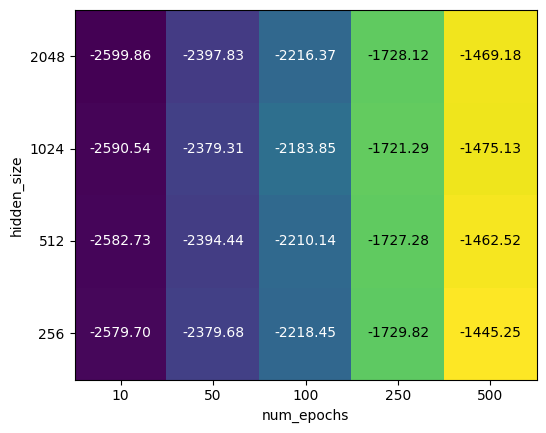

In [ ]:
results_epoch_hidden_size = pd.DataFrame(grid_search.cv_results_)
scores_epoch_hidden_size = np.array(results_epoch_hidden_size.mean_test_score).reshape(4, 5)
## epochs and hidden_size
heat_grid(scores_epoch_hidden_size, 'num_epochs', 'hidden_size')

# hidden_size [256, 512, 1024, 2048]는 상관없다? => 256으로 하자


" \n파라미터 설정\nparam_grid = {\n    'num_epochs': [700, 1000, 1500],\n    'input_size': [4096],\n    'hidden_size': [256],\n    'dropout_rate': [0.2],   #[0.2, 0.5, 0.8],\n    'learning_rate': [0.1],  #[0.1, 0.01, 0.001],\n    'batch_size': [64],  #[64, 128, 256]    \n}\n\n"

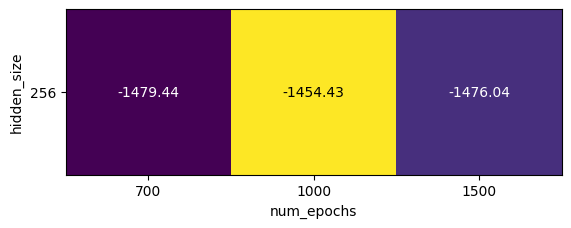

In [ ]:
results_epoch_hidden_size = pd.DataFrame(grid_search.cv_results_)
scores_epoch_hidden_size = np.array(results_epoch_hidden_size.mean_test_score).reshape(1, 3)
## epochs and hidden_size
heat_grid(scores_epoch_hidden_size, 'num_epochs', 'hidden_size')

## epoch이 1000일때 성능이 가장 좋다?
"""
파라미터 설정
param_grid = {
    'num_epochs': [700, 1000, 1500],
    'input_size': [4096],
    'hidden_size': [256],
    'dropout_rate': [0.2],   #[0.2, 0.5, 0.8],
    'learning_rate': [0.1],  #[0.1, 0.01, 0.001],
    'batch_size': [64],  #[64, 128, 256]
}

"""

"\nparam_grid = {\n    'num_epochs': [1000], # fix?\n    'input_size': [4096], # fix\n    'hidden_size': [256], # fix?\n    'dropout_rate': [0.2, 0.5, 0.8],   #[0.2, 0.5, 0.8],\n    'learning_rate': [0.1, 0.01, 0.001],  #[0.1, 0.01, 0.001],\n    'batch_size': [64],  #[64, 128, 256]    \n}\n"

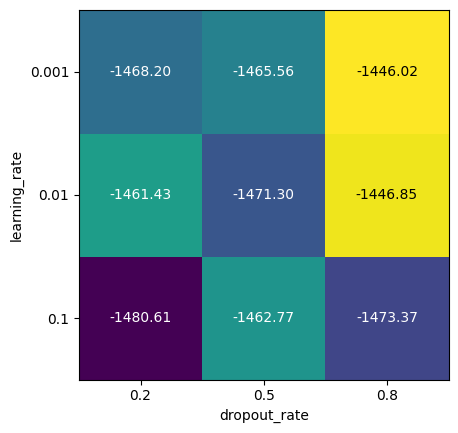

In [ ]:
results_drop_lr = pd.DataFrame(grid_search.cv_results_)
scores_drop_lr = np.array(results_drop_lr.mean_test_score).reshape(3, 3)
## dropout_rate and learning_rate
heat_grid(scores_drop_lr, 'dropout_rate', 'learning_rate')

## dropout이 0.8일때 성능이 괜찮다. lr_rate는 다시 확인해보자.
"""
param_grid = {
    'num_epochs': [1000], # fix?
    'input_size': [4096], # fix
    'hidden_size': [256], # fix?
    'dropout_rate': [0.2, 0.5, 0.8],   #[0.2, 0.5, 0.8],
    'learning_rate': [0.1, 0.01, 0.001],  #[0.1, 0.01, 0.001],
    'batch_size': [64],  #[64, 128, 256]
}
"""

"\nparam_grid = {\n    'num_epochs': [1000], # fix?\n    'input_size': [4096], # fix\n    'hidden_size': [256], # fix?\n    'dropout_rate': [0.8], # fix?\n    'learning_rate': [0.1, 0.01, 0.001],  #[0.1, 0.01, 0.001],\n    'batch_size': [64, 128, 256]    \n}\n"

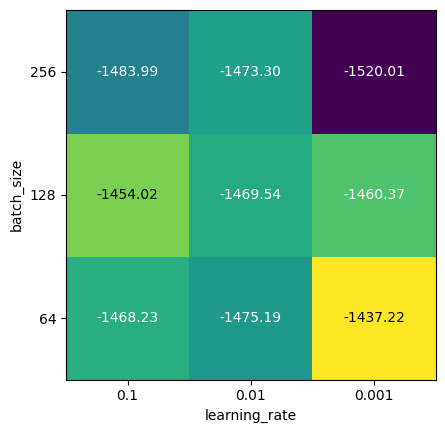

In [ ]:
results_lr_batch = pd.DataFrame(grid_search.cv_results_)
scores_lr_batch  = np.array(results_lr_batch .mean_test_score).reshape(3, 3)
## dropout_rate and learning_rate
heat_grid(scores_lr_batch , 'learning_rate', 'batch_size')

## batch_size가 64일때가 성능이 괜찮네
"""
param_grid = {
    'num_epochs': [1000], # fix?
    'input_size': [4096], # fix
    'hidden_size': [256], # fix?
    'dropout_rate': [0.8], # fix?
    'learning_rate': [0.1, 0.01, 0.001],  #[0.1, 0.01, 0.001],
    'batch_size': [64, 128, 256]
}
"""


"\nparam_grid = {\n    'num_epochs': [900, 1000, 1100], # fix?\n    'input_size': [4096], # fix\n    'out_size': [1],\n    'hidden_size': [256], # fix?\n    'dropout_rate': [0.8], # fix?\n    'learning_rate': [0.001],  # fix?\n    'batch_size': [64]    \n}\n"

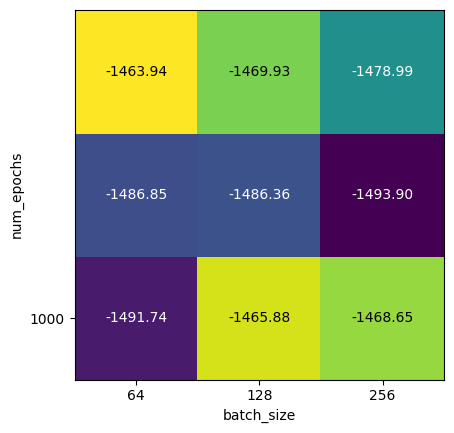

In [ ]:
results_epochs = pd.DataFrame(grid_search.cv_results_)
scores_epochs  = np.array(results_epochs .mean_test_score).reshape(3, 3)
# dropout_rate and learning_rate
heat_grid(scores_epochs , 'batch_size' , 'num_epochs')

## epochs 범위 줄이기
"""
param_grid = {
    'num_epochs': [900, 1000, 1100], # fix?
    'input_size': [4096], # fix
    'out_size': [1],
    'hidden_size': [256], # fix?
    'dropout_rate': [0.8], # fix?
    'learning_rate': [0.001],  # fix?
    'batch_size': [64]
}
"""

"\nparam_grid = {\n    'num_epochs': [ 900, 1000, 1100, 1200], # fix?\n    'input_size': [4096], # fix\n    'out_size': [1],\n    'hidden_size': [256], # fix?\n    'dropout_rate': [0.0, 0.2, 0.5, 0.8], # fix?\n    'learning_rate': [0.001],  # fix?\n    'batch_size': [64]    \n}\n"

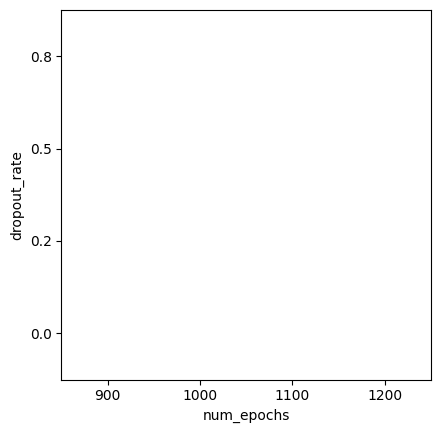

In [ ]:
results_epochs_dropout = pd.DataFrame(grid_search.cv_results_)
scores_epochs_dropout  = np.array(results_epochs_dropout .mean_test_score).reshape(4, 4)
# dropout_rate and learning_rate
heat_grid(scores_epochs_dropout, 'num_epochs' , 'dropout_rate')

## epochs와 dropout
"""
param_grid = {
    'num_epochs': [ 900, 1000, 1100, 1200], # fix?
    'input_size': [4096], # fix
    'out_size': [1],
    'hidden_size': [256], # fix?
    'dropout_rate': [0.0, 0.2, 0.5, 0.8], # fix?
    'learning_rate': [0.001],  # fix?
    'batch_size': [64]
}
"""

In [ ]:
# Get the best hyperparameters
best_params = grid_search.best_params_
best_params


{'batch_size': 64,
 'dropout_rate': 0.0,
 'hidden_size': 256,
 'input_size': 4096,
 'learning_rate': 0.001,
 'num_epochs': 900,
 'out_size': 1}

In [ ]:
best_params = {'batch_size': 256,
                'dropout_rate': 0.0,
                'hidden_size': 256,
                'input_size': 4096,
                'learning_rate': 0.1,
                'out_size': 1,
                'num_epochs': 900}

In [ ]:
# Train the final model on the entire training data using the best hyperparameters
final_model_MLM = PyTorchRegressor(**best_params)
final_model_MLM.fit(X_train_tensor, y_train_MLM)

100%|██████████| 900/900 [08:15<00:00,  1.82it/s]


PyTorchRegressor(batch_size=256, dropout_rate=0.0, hidden_size=256,
                 input_size=4096, learning_rate=0.1, num_epochs=900,
                 out_size=1)

In [ ]:
# Train the final model on the entire training data using the best hyperparameters
final_model_HLM = PyTorchRegressor(**best_params)
final_model_HLM.fit(X_train_tensor, y_train_HLM)

100%|██████████| 900/900 [07:59<00:00,  1.88it/s]


PyTorchRegressor(batch_size=256, dropout_rate=0.0, hidden_size=256,
                 input_size=4096, learning_rate=0.1, num_epochs=900,
                 out_size=1)

In [ ]:
test_df

,FPs
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
478,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
479,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ..."
480,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
481,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
X_test_tensor = torch.tensor(test_df['FPs'], dtype=torch.float32)

In [ ]:
final_model_MLM

PyTorchRegressor(batch_size=256, dropout_rate=0.0, hidden_size=256,
                 input_size=4096, learning_rate=0.1, num_epochs=900,
                 out_size=1)

In [ ]:
# Evaluate the final model on the test set
test_predictions_MLM = final_model_MLM.predict(X_test_tensor)

In [ ]:
# Evaluate the final model on the test set
test_predictions_HLM = final_model_HLM.predict(X_test_tensor)

In [ ]:
pwd

'/content/drive/MyDrive/bioAI'

In [ ]:
submission = pd.read_csv('./data/submission/sample_submission.csv')

In [ ]:
submission['MLM'] = test_predictions_MLM

In [ ]:
submission['HLM'] = test_predictions_HLM


In [ ]:
submission.to_csv('baseline_submission_0914_2.csv', index=False)